# Hands-on scRNAseq data analysis mini workshop

Rance Nault <br>
Michigan State University <br>
June 14, 2024 <br>

---------------------------------------
### Overview
<img src="link.png">

This notebook was developed as a hands-on walkthrough for single-cell analysis using 10X Genomics single-cell/nuclei RNA sequencing data. It is intended to be run on the [<b>MSU High Performance Computing Cluster (HPCC)</b>](https://icer.msu.edu/), but can also be adopted for running most other Linux servers/clouds. This workbook is split into 3 major sections:

- [<b>Setting up your analysis environment (section 1).</b>](#environment)
- [<b>Alignment of sequencing reads (section 2).</b>](#alignment)
- [<b>Preliminary analysis with python (section 3).</b>](#scanpy)

<b>Learning objectives</b>
- Be able to install and use the 10X Genomics CellRanger program.
- Understand sequencing read alignment and preliminary QC.
- Know how to create a custom reference genome for non-model organisms.
- Run simple QC and visualization of single-cell data in Python.

---

## <b>1. Setting up your analysis environment</b> <a id="environment"></a>

This workshop will use the 10X Genomics CellRanger software as it is currently one of the most widely used platforms for single-cell sequencing. Tutorials for this and other workflows can be found at the following links:

[10X Genomics](https://www.10xgenomics.com/support/software/cell-ranger/latest/tutorials/cr-tutorial-in)

[Parse BioSciences](https://www.parsebiosciences.com/)

[Curio BioSciences](www.curiobiosciences.com)

[Scale BioSciences](https://www.scale.bio)

<b><i>Useful tip:</i></b> In this interactive notebook you will see the character <b>"!"</b> used at the start of several lines of code. This is a trick we can use to run code on the <i>command line</i>. Another way to run this is to simply open a terminal and copy the code. We use this here to keep all the code together and make sure it is run from the correct location.

#### <b>1.a. Download and test CellRanger</b>

Each single-cell platform will recommend analysis workflows. 10X Genomics have their own software called <i>CellRanger</i> which does the alignment and identifies cells from empty GEMs. Here we will install the most recent version of CellRanger. Note that the link will regularly change so be sure to go to the vendor website directly for installation instructions. Use the link provided there to replace `<link to cellranger-8.0.0.tar.gz>`. <b><u>Always</u> record your software versions!</b>

In [ ]:
import os

# Step 1: Define the URL and the destination path
url = "<link to cellranger-8.0.0.tar.gz>"
destination = os.path.join(os.environ['HOME'], 'cellranger-8.0.0.tar.gz')

# Download the file using wget
!wget -O {destination} {url}

# Unpack the cellranger software in the $HOME directory
!tar -xzvf {destination} -C {os.environ['HOME']}

# Step 2: Export the PATH to include cellranger
cellranger_path = os.path.join(os.environ['HOME'], 'cellranger-8.0.0')
os.environ['PATH'] = f"{cellranger_path}:{os.environ['PATH']}"

# Verify the PATH has been updated
print(os.environ['PATH'])

> Run the following chunk only if you've already installed cellranger - do not run the previous one.

In [8]:
import os

# Step 2: Export the PATH to include cellranger
cellranger_path = os.path.join(os.environ['HOME'], 'cellranger-8.0.0')
os.environ['PATH'] = f"{cellranger_path}:{os.environ['PATH']}"

# Verify the PATH has been updated
print(os.environ['PATH'])

/mnt/home/naultran/cellranger-8.0.0:/mnt/home/naultran/cellranger-8.0.0:/mnt/home/naultran/anaconda3/envs/spipe/bin:/mnt/home/naultran/anaconda3/bin:/mnt/home/naultran/anaconda3/condabin:/opt/software/R/4.0.3-foss-2020a/bin:/opt/software/GLPK/4.65-GCCcore-9.3.0/bin:/opt/software/ImageMagick/7.0.10-1-GCCcore-9.3.0/bin:/opt/software/LittleCMS/2.9-GCCcore-9.3.0/bin:/opt/software/JasPer/2.0.14-GCCcore-9.3.0/bin:/opt/software/Ghostscript/9.52-GCCcore-9.3.0/bin:/opt/software/GSL/2.6-GCC-9.3.0/bin:/opt/software/UDUNITS/2.2.26-foss-2020a/bin:/opt/software/HDF5/1.10.6-gompi-2020a/bin:/opt/software/ICU/66.1-GCCcore-9.3.0/sbin:/opt/software/ICU/66.1-GCCcore-9.3.0/bin:/opt/software/libsndfile/1.0.28-GCCcore-9.3.0/bin:/opt/software/cURL/7.69.1-GCCcore-9.3.0/bin:/opt/software/Tk/8.6.10-GCCcore-9.3.0/bin:/opt/software/Java/11.0.2:/opt/software/Java/11.0.2/bin:/opt/software/LibTIFF/4.1.0-GCCcore-9.3.0/bin:/opt/software/libjpeg-turbo/2.0.4-GCCcore-9.3.0/bin:/opt/software/NASM/2.14.02-GCCcore-9.3.0/bin:

### <b>1.b. Run a sitecheck (check package)</b>
We will check that your system meets the requirements to run the cellranger pipeline. A description of each of the sections below can be found on the [10X Genomics tutorial](https://www.10xgenomics.com/support/software/cell-ranger/latest/tutorials/cr-tutorial-in). Note that you will need at least 8 CPU cores. If you did not request this many cores, start a new interactive instance with the necessary resources.

In [10]:
import os

# Define the path to the logs folder
logs_folder = '../logs'

# Create the logs folder if it doesn't exist
if not os.path.exists(logs_folder):
    os.makedirs(logs_folder)

# Run the cellranger sitecheck command and redirect output to logs/sitecheck.txt
!cellranger sitecheck > ../logs/sitecheck.txt

This will generate a file called sitecheck.txt in your logs folder. Most of the time you will not need it, but it is good to have when things don't work as expected.

### <b>1.c. Perform test run</b>

To verify the CellRanger installation we will do a test run. This can take up to 15 minutes.

In [11]:
!cellranger testrun --id=check_install > ../logs/test_run.txt

Once again you will have a new file in the logs folder. Check that this file ends with something like <b>pipestance completed successfully</b>. If it ran correctly then your own analysis should have no problems.

### <b>1.d. Downloading a reference genome</b>

You will typically use a reference genome to align your sequencing reads to the genome of your model organism and get gene counts. Some vendors keep reference genomes in a format compatible with their software for a handful of the most common model organisms: Human, mouse, rat, drosophila, etc. See ["Build a custom reference for cell ranger (mkref)"](https://www.10xgenomics.com/support/software/cell-ranger/latest/tutorials/cr-tutorial-mr) for a tutorial on creating a reference genome for non-model organisms. Here we will work with the [mouse reference genome from 10X Genomics](https://www.10xgenomics.com/support/software/cell-ranger/downloads#reference-downloads).

*Note: Always record the version number, genome build, and any other information about the source to ensure that you can reproduce your results.*

In [11]:
# Extract the files
!tar -xzvf refdata-gex-GRCm39-2024-A.tar.gz

tar (child): refdata-gex-GRCm39-2024-A.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


### <b>1.e. Custom reference</b>

The example below creates a custom reference genome for cow samples (Bos taurus). References datasets can be obtained from the [Ensembl ftp server](https://useast.ensembl.org/info/data/ftp/index.html).

In [ ]:
# Download FASTA genome
# This is Bos taurus release 111 (ARS-UCD1.3) released by the USDA ARS in May 2022
# Uncomment wget lines and comment cp lines if working on your own environment

!wget https://ftp.ensembl.org/pub/release-111/fasta/bos_taurus/dna/Bos_taurus.ARS-UCD1.3.dna.toplevel.fa.gz
#!cp ./drive/My\ Drive/SIVBWorkshop_Files/Bos_taurus.ARS-UCD1.3.dna.toplevel.fa.gz .
!gunzip Bos_taurus.ARS-UCD1.3.dna.toplevel.fa.gz

# Download the gene models (GTF)
!wget https://ftp.ensembl.org/pub/release-111/gtf/bos_taurus/Bos_taurus.ARS-UCD1.3.111.gtf.gz
!gunzip Bos_taurus.ARS-UCD1.3.111.gtf.gz

--2024-05-20 19:01:40--  https://ftp.ensembl.org/pub/release-111/fasta/bos_taurus/dna/Bos_taurus.ARS-UCD1.3.dna.toplevel.fa.gz
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.169
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 817680774 (780M) [application/x-gzip]
Saving to: ‘Bos_taurus.ARS-UCD1.3.dna.toplevel.fa.gz’

 1% [                                       ] 15,135,689  7.99MB/s             

#### <b>Filtering gene models</b>

We choose what time of RNA molecules we want to include for the sequence alignment. Because the cow is not as well defined or annotated compared to typical model organisms we will only include protein coding (gene_biotype:protein_coding) genes. This step can take several minutes.

In [ ]:
# Keep only protein coding, lncRNA, and antisense genes
!cellranger mkgtf \
Bos_taurus.ARS-UCD1.3.111.gtf Bos_taurus.ARS-UCD1.3.111.filtered.gtf \
--attribute=gene_biotype:protein_coding
#--attribute=gene_biotype:lncRNA \
#--attribute=gene_biotype:antisense



Writing new genes GTF file (may take 10 minutes for a 1GB input GTF file)...
...done



#### <b>Building reference genome</b>

We are creating a Btau_10 folder which has reformmed the genome to work with cellranger. This step can take up to an hour.

In [ ]:
# Run mkref (build reference genome)
!cellranger mkref \
--genome=Btau_10 \
--fasta=Bos_taurus.ARS-UCD1.3.dna.toplevel.fa \
--genes=Bos_taurus.ARS-UCD1.3.111.filtered.gtf \
--ref-version=1.0.0

---

## <b>2. Alignment of sequencing reads</b> <a id="alignment"></a>

Most sequencing cores will send you your sequencing results in a **FASTQ** format. In very rare instances you may beed to convert raw output BCL files according to vendor instructions.

### <b>2.a. What is a FASTQ file?</b>

FASTQ data will consist of four-line [repeating patterns](https://en.wikipedia.org/wiki/FASTQ_format):
@ERR059938.60 HS9_6783:8:2304:19291:186369#7/2
GTCTCCGGGGGCTGGGGGAACCAGGGGTTCCCACCAACCACCCTCACTCAGCCTTTTCCCTCCAGGCATCTCTGGGAAAGGACATGGGGCTGGTGCGGGG
+
7?CIGJB:D:-F7LA:GI9FDHBIJ7,GHGJBKHNI7IN,EML8IFIA7HN7J6,L6686LCJE?JKA6G7AK6GK5C6@6IK+++?5+=<;227*6054

in short, <br>
**line 1** is instrument information. <br>
**line 2** is the raw sequence letters. <br>
**line 3** can optionally provide additional sequence information. <br>
**line 4** encodes the quality values. <br>

In [ ]:
# Display the first 10 lines of a fastq file
!head <insert path to your fastq file here>

@A00984:764:HW7WGDSX3:1:1101:1163:1000 1:N:0:NAATCCCGAC+TACTACTCGG
AAAGGTATCTCTCTTCCTCCACACCACA
+
,FFFF,,F,F:FFFFFFFFFFF:FFFFF
@A00984:764:HW7WGDSX3:1:1101:6153:1000 1:N:0:CAATCCCGAC+TACTACTCGG
CATTGATTCGGTCATATGCCTTCAGGGG
+
F,F,FFFF:FFFF,FFF,F:FFFFFFFF
@A00984:764:HW7WGDSX3:1:1101:6858:1000 1:N:0:CAATCCCGAC+TACTACTCGG
ATTCATCTCATGGGAGGTCTTCGTATCG


### <b>2.b. Run FASTQ alignments</b>

This step can take several hours depedent on the number of cores used.

In [ ]:
# Uncomment this if the run previously failed
#!rm -r run_count_5kliver
!./cellranger-8.0.0/cellranger count \
--id=run_count_5kliver \                      # Give the analysis an ID
--fastqs=./5k_mouse_liver_CNIK_3pv3_fastqs/ \ # The folder with FASTQ files
--sample=5k_mouse_liver_CNIK_3pv3 \           # A commong string in the names
--transcriptome=./refdata-gex-GRCm39-2024-A \ # The reference genome
--create-bam=false \                          # Don't create a BAM file
--nosecondary \                               # Don't create a secondary index
--localmem=8 \                                # Use 8MB of local memory
--localcores=1                                # Use 1 local CPU

<b><i>Handling multiple samples (parallel processing)</i></b>

Because each analysis can take several hours we can take advantage of the MSU HPC to do this step in <i>parallel</i>. This means that we submit <b><i>jobs</i></b> which are self-contained pieces of code than are scheduled to run on the [thousands of computing nodes](https://docs.icer.msu.edu/Cluster_Resources/) available to us on the HPC. For more details on writing and submitting jobs [see here](https://docs.icer.msu.edu/Job_Script_and_Job_Submission/).

In [13]:
# Python package do handle command-line arguments
import os
import subprocess

analysis_path = '/mnt/gs21/scratch/naultran/SIVB-HPC-Tutorial/'
out_path = analysis_path + 'Logs/'
sbatch_path = analysis_path + 'Code/CellRangerAlignment.sbatch'

run_ids = ['run_HF_mes_PVAT', 'run_mes2X_PVAT', 'run_RP_fat', 'run_cow_fat']
fastq_paths = [analysis_path + 'Data/HF_mes_PVAT', analysis_path + 'Data/mes2X_PVAT', analysis_path + 'Data/RP_fat', analysis_path + 'Data/cow_fat']
samples = ['HF_mes_PVAT_CKDL240015445-1A_22KKKMLT3', 'mes2X_PVAT_CKDL240015448-1A_22KKKMLT3', 'RP_fat_CKDL240015446-1A_22KKKMLT3', 'cow_fat_CKDL240015447-1A_22KKKMLT3']
transcriptomes = [analysis_path + 'References/Rnor7_2_genome', 
                  analysis_path + 'References/Rnor7_2_genome', 
                  analysis_path + 'References/Rnor7_2_genome', 
                  analysis_path + 'References/Btau_10'
                 ]

# Iterate through the indices of the lists
#for i in range(len(run_ids)):
for i in range(3,4):
    run_id = run_ids[i]
    print(run_id)
    sample_path = fastq_paths[i]
    sample_ID = samples[i]
    transcriptome = transcriptomes[i]
    
    command_job = ["sbatch", f"--job-name={run_id}", f"--output={out_path}/{run_id}.SLURMout", \
                   f"--error={out_path}/{run_id}.SLURMerr", \
                   f"--export=FASTQ_PATH={sample_path},RUN_ID={run_id},SAMPLE={sample_ID},TRANSCRIPTOME={transcriptome}", f"{sbatch_path}"]
    command_job_str = " ".join(command_job)
    subprocess.check_call(command_job_str, shell=True)

run_cow_fat
Submitted batch job 35288358


### <b>2.c. Examination of outputs</b>

The `count` command will create a new folder named based on what you used for `--id=` in the command above. This folder will contain several files and folers. You want to examine the <b>outs</b> folder which will contain most of the files you need for the subsequent analyses. Start with the <i> web_summary.html</i> file.

The HTML web summary provides a lot of useful information. Each piece should be examined closely but with the biology in mind. Some of the key metrics to examine are <b> Estimated number of cells </b>, <b> mean and median reads/genes per cells</b>, <b> valid barcodes </b>, and the <b> Barcode Rank Plot </b> (also known as the <i>knee plot</i>).

- The estimated number of cells should be close to what you expected based on your loading concentration during the library preparation (wet lab steps).
- Mean reads and median genes should reflect your sequencing depth but will vary depending on tissue and its general RNA abundance.
- The number of valid barcodes and reads should be high (> 85%).
- You will get warnings and errors messages at the top of the summary page.
- The Barcode Rank Plot should have a very clear bend (<i>knee</i>) which distinguishes your cells from background signal.  

---

## <b>3. Advanced analysis using scanpy/scVI</b><a id="scanpy"></a>


### <b>3.a. Setting up python environment</b>

We need to ensure that all the necessary packages are available. Typically this is done by setting up a virtual environment. Because we run this notebook as part of the tutorial we should have already set up your virtual environment. However, if you needs to create a new one, here is how this could be accomplished:

```{bash}
conda create
```

In [1]:
# Import the analysis packages
# Run pip install <package-name> if these are not in your environment
import scvi
import scanpy as sc
import numpy as np
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad

import warnings

# Suppress FutureWarnings (easier to read)
warnings.filterwarnings("ignore")

/mnt/home/naultran/anaconda3/envs/spipe/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[rank: 0] Global seed set to 0
/mnt/home/naultran/anaconda3/envs/spipe/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/mnt/home/naultran/anaconda3/envs/spipe/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


Because we will be generating plots, we will also set some default setting for those images. 

In [2]:
# Set plotting settings
sc.set_figure_params(
    scanpy=True,            # Boolean flag to use Scanpy's default figure settings
    dpi=300,                # DPI for on-screen figures; higher value means higher resolution
    dpi_save=600,           # DPI for saving figures; higher value means higher resolution
    frameon=True,           # Boolean flag to include a frame around figures
    vector_friendly=True,   # Optimize vector graphics for better rendering quality
    fontsize=14,            # Default font size for figures
    figsize=None,           # Figure size as a tuple (width, height) in inches; None uses default size
    color_map=None,         # Default colormap for figures; None uses the default colormap
    format='png',           # File format for saving figures; common values: 'png', 'pdf', 'svg'
    facecolor=None,         # Face color (background color) of the figure; None uses default color
    transparent=False,      # Boolean flag for transparent figure background when saving
    ipython_format='pdf'    # Format for displaying figures in IPython environments; common values: 'png', 'jpeg', 'svg', 'pdf'
)

### <b>3.b. Defining sample names and path to outputs</b>

There are several ways to provide sample information to your analysis code so that it is tracked throughout the process. <b> You want to provide as comprehensive metadata as possible <i>(see FAIR data principles)</i></b>. Because we will only use 1 sample I prepare a table manually, but pandas can be used to import a table with metadata.

Here we will follow the [requirements from the Broad Single-Cell Portal](https://singlecell.zendesk.com/hc/en-us/articles/360060609852-Required-Metadata).

| Metadata Name                        | Content           | Description                                                                                     |
|--------------------------------------|-------------------|-------------------------------------------------------------------------------------------------|
| NAME                                 | string            | unique identifier for each cell in the study. Must be the first column in a metadata file        |
| biosample_id                         | string            | unique identifier for each sample in the study                                                  |
| donor_id                             | string            | unique identifier for each biosample donor in the study                                         |
| species                              | ontology          | ontology identifier from NCBItaxon                                                              |
| species__ontology_label              | ontology_label    | ontology label from NCBItaxon                                                                   |
| disease                              | ontology          | ontology identifier from MONDO or PATO (if no disease, use ontology ID "PATO_0000461")          |
| disease__ontology_label              | ontology_label    | ontology label from MONDO or PATO (if no disease, use ontology label "normal")                  |
| organ                                | ontology          | ontology identifier from Uberon                                                                 |
| organ__ontology_label                | ontology_label    | ontology label from Uberon                                                                      |
| library_preparation_protocol         | ontology          | ontology identifier from Experimental Factor ontology: library preparation                      |
| library_preparation_protocol__ontology_label | ontology_label    | ontology label from Experimental Factor ontology: library preparation                      |
| sex                                  | controlled list (enum) | one of ["male", "female", "mixed", "unknown"]                                                |

In [20]:
# List the analysis IDs created with CellRanger
run_ids = ['run_HF_mes_PVAT', 'run_mes2X_PVAT', 'run_RP_fat', 'run_cow_fat']

# We manually create the table. It is often easier to import one!
data = {
    'path': ['../Output/run_HF_mes_PVAT/outs/filtered_feature_bc_matrix', 
             '../Output/run_mes2X_PVAT/outs/filtered_feature_bc_matrix',
             '../Output/run_RP_fat/outs/filtered_feature_bc_matrix',
             '../Output/run_cow_fat/outs/filtered_feature_bc_matrix'
            ],
    'biosample_id': ['HF_mes_PVAT', 'mes2X_PVAT', 'RP_fat', 'cow_fat'],  # Unique identifier for each biosample
    'donor_id': ['D001', 'D002', 'D003', 'D004'],  # Unique identifier for each donor
    'species': ['NCBITaxon_10116', 'NCBITaxon_10116', 'NCBITaxon_10116', 'NCBITaxon_9913'],  # Ontology terms for species
    'species__ontology_label': ['Rattus norvegicus', 'Rattus norvegicus', 'Rattus norvegicus', 'Bos taurus'],  # Common names for species
    'disease': ['PATO_0000461', 'PATO_0000461', 'PATO_0000461', 'PATO_0000461'],  # Ontology terms for disease
    'disease__ontology_label': ['Normal', 'Normal', 'Normal', 'Normal'],  # Disease labels
    'organ': ['UBERON_0001013', 'UBERON_0001013', 'UBERON_0001013', 'UBERON_0001013'],  # Ontology terms for organ
    'organ__ontology_label': ['Adipose tissue', 'Adipose tissue', 'Adipose tissue', 'Adipose tissue'],  # Organ labels
    'library_preparation_protocol': ['EFO_0009922', 'EFO_0009922', 'EFO_0009922', 'EFO_0009922'],  # Ontology terms for library preparation protocol
    'library_preparation_protocol__ontology_label': ["10x 3' v3", "10x 3' v3", "10x 3' v3", "10x 3' v3"],  # Library preparation protocol labels
    'sex': ['Male', 'Male', 'Male', 'Male'],  # Sex of the donor
    'tissue': ['Mesenteric Adipose Tissue', 'Mesenteric Adipose Tissue', 'Retroperitoneal Adipose Tissue', 'Adipose Tissue'],  # Type of tissue
    'diet': ['HFD', 'Control', 'Control', 'Control'],
}

# Create the DataFrame
sample_details_df = pd.DataFrame(data)

### <b>3.c. Import and perform preliminary QC on filtered data</b>

The following code does the following for each row in the table we just created.

- Imports the data using `read_10x_mtx`.
- Builds the metadata from the table created above.
- Calculates QC metrics
- Saves the outputs in a <i>list</i>.

In [21]:
adata_list = []

for index, sample in sample_details_df.iterrows():
    print(sample['path'])
    adata = sc.read_10x_mtx(sample['path'])

    # Build metadata
    for column in sample_details_df.columns:
        if column != 'path':  # Skip the 'path' column
            adata.obs[column] = sample[column]

    # Calculate QC metrics
    adata.var["mt"] = adata.var_names.str.startswith('Mt-')  # annotate the group of mitochondrial genes as 'mt'
    adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))
    adata.var["hb"] = adata.var_names.str.startswith(("Hbb", "Hbc"))
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], percent_top=[20],
                               log1p=True, inplace=True)

    adata_list.append(adata)

new_adata = sc.concat(adata_list, join='outer', index_unique=None, fill_value=0)

# Make observation names unique
new_adata.obs_names_make_unique()

../Output/run_HF_mes_PVAT/outs/filtered_feature_bc_matrix
../Output/run_mes2X_PVAT/outs/filtered_feature_bc_matrix
../Output/run_RP_fat/outs/filtered_feature_bc_matrix
../Output/run_cow_fat/outs/filtered_feature_bc_matrix


#### <b>SAVE YOUR ANALYSIS!</b>

We will not be as diligent in this tutorial about saving, but <b> it is wise to regularly save your analysed data</b>. This allows you to restart at specific stopping points if anything needs to be changed.

In [22]:
# Save to h5ad object using a name that makes sense
new_adata.write('../Output/concatenated_QCstep1.h5ad') 

In [14]:
# Import the h5ad if starting here

new_adata = ad.read('../Output/concatenated_QCstep1.h5ad')

#### <b> QC - basic metrics</b>

The most common preliminary QC metrics are the number of genes, transcripts, and mitochondrial RNA detected in each of your cells. These outputs can help identify unhealthy cells (high mitochondrial contamination), poor quality <i>cells</i> which have little/no RNA or putative doublets which have <i>too much</i> RNA.

In [23]:
# Create a violin plot for quality control metrics
sc.pl.violin(new_adata,                    # The AnnData object containing your single-cell data
             keys=['pct_counts_mt',        # List of keys to plot; here, 'pct_counts_mt' represents the percentage of mitochondrial gene counts
                   'pct_counts_ribo',      # 'pct_counts_ribo' represents the percentage of ribosomal gene counts
                   'n_genes_by_counts',    # 'n_genes_by_counts' represents the number of genes with counts
                   'total_counts'],        # 'total_counts' represents the total counts per cell
             groupby='biosample_id',       # Grouping variable; in this case, 'biosample_id' to group by biosample ID
             rotation=90,                  # Rotation of x-axis labels for better readability
             save='_quality_control_Step1.png'  # Filename to save the plot; adds '_quality_control_Step1.png' to the base plot name
             )

<Figure size 5583.6x1200 with 4 Axes>

We can also visualize all of these metrics together as a scatter plot. Here the number of genes and total counts should be positively correlated.

In [24]:
# Loop through each AnnData object in the list adata_list
for data in adata_list:
    #Extract the sample name
    sample = str(data.obs['biosample_id'][0])
    
    # Create a scatter plot for each AnnData object
    sc.pl.scatter(data,                             # The current AnnData object in the loop
                  x="total_counts",                  # The x-axis variable; here, the total counts per cell
                  y="n_genes_by_counts",             # The y-axis variable; here, the number of genes detected per cell
                  color="pct_counts_mt",             # The color variable; here, the percentage of mitochondrial gene counts
                  title=f'Scatter for {sample}',
                  save=sample + '_scatter_QC1.png'  # Filename to save the plot; dynamically generated based on the biosample ID
                 )

<Figure size 1353.75x1200 with 2 Axes>

<Figure size 1353.75x1200 with 2 Axes>

<Figure size 1353.75x1200 with 2 Axes>

<Figure size 1353.75x1200 with 2 Axes>

### <b>3.e. Filter based on QC metrics</b>

Here we filter cells with fewer than 100 genes and genes detected in fewer than 3 cells.

In [8]:
for idx, item in enumerate(adata_list):
    sc.pp.filter_cells(item, min_genes=100)
    #sc.pp.filter_genes(item, min_cells=3)
    item = item[item.obs['pct_counts_mt'] < 5, :]
    item = item[item.obs['total_counts'] < 25000, :]
    item = item[item.obs['n_genes_by_counts'] < 7000, :]
    adata_list[idx] = item

new_adata = sc.concat(adata_list, join='outer', index_unique=None, fill_value=0)

# Create a violin plot for quality control metrics
sc.pl.violin(new_adata,                    # The AnnData object containing your single-cell data
             keys=['pct_counts_mt',        # List of keys to plot; here, 'pct_counts_mt' represents the percentage of mitochondrial gene counts
                   'pct_counts_ribo',      # 'pct_counts_ribo' represents the percentage of ribosomal gene counts
                   'n_genes_by_counts',    # 'n_genes_by_counts' represents the number of genes with counts
                   'total_counts'],        # 'total_counts' represents the total counts per cell
             groupby='biosample_id',       # Grouping variable; in this case, 'biosample_id' to group by biosample ID
             rotation=90,                  # Rotation of x-axis labels for better readability
             save='_quality_control_Step2.png'  # Filename to save the plot; adds '_quality_control_Step1.png' to the base plot name
             )

<Figure size 5583.6x1200 with 4 Axes>

### <b>3.e. Removal of ambient RNA and doublets</b>

Doublets and ambient RNA can sometimes pose significant analysis and interpretation challenges downstream if not accounted for properly. The extent to which these factors affect your data will largely depend on the wet lab steps of single-cell RNA sequencing. For example, nuclei isolation can often lead to elevated ambient RNA resulting from the release of cytosolic RNA. Similarly, overloading cells can increase the doublet rate leading to cells with artificially high counts. <b> Protocol optimization is crucial to minimize the impact of these issues.</b>

To run some of these cleanup steps you can explore the following popular tools (<i>not a comprehensive list</i>) and their associated tutorials:
- [SoupX](https://academic.oup.com/gigascience/article/9/12/giaa151/6049831?login=false) - ambient RNA removal
- [scDblFinder](https://doi.org/10.12688%2Ff1000research.73600.2) - Doublet detection
- [Scrublet](https://www.sciencedirect.com/science/article/pii/S2405471218304745) - Doublet detection

In this analysis we will use two R packages. This means that we have to use <i>creative</i> ways to get the data from here (<i>Python</i>) to R, then back. This next block allows us to do this.

In [25]:
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

#### <b>Ambient RNA removal using SoupX</b>

In [26]:
%%R

.libPaths('/mnt/home/naultran/Rlocal4.0.3/R_libs/')

library(SoupX)
library(scDblFinder)

#' This function performs SoupX correction on the provided count data.
#' 
#' @param data A sparse matrix containing the raw counts data. Rows represent genes, and columns represent cells.
#' @param raw A sparse matrix containing the raw counts data of the droplets.
#' @param genes A character vector containing the names of genes.
#' @param cells A character vector containing the names of cells.
#' @param soupx_groups A vector specifying the groupings of cells used in SoupX.
#' 
#' @return A matrix containing the corrected counts data.
#' 
#' @export
make_soup <- function(data, raw, genes, cells, soupx_groups){
    # specify row and column names of data
    rownames(data) = genes
    colnames(data) = cells
    # ensure correct sparse format for table of counts and table of droplets
    data <- as(data, "sparseMatrix")
    raw <- as(raw, "sparseMatrix")

    # Generate SoupChannel Object for SoupX 
    sc = SoupChannel(raw, data, calcSoupProfile = FALSE)

    # Add extra metadata to the SoupChannel object
    soupProf = data.frame(row.names = rownames(data), est = rowSums(data)/sum(data), counts = rowSums(data))
    sc = setSoupProfile(sc, soupProf)
    # Set cluster information in SoupChannel
    sc = setClusters(sc, soupx_groups)

    # Estimate contamination fraction
    sc  = autoEstCont(sc, doPlot=FALSE, forceAccept=TRUE)
    # Infer corrected table of counts and round to integer
    out = adjustCounts(sc, roundToInt = TRUE)
    
    return(out)
}


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [27]:
def get_soupx_group(adata):
    adata_pp = adata.copy()
    sc.pp.normalize_per_cell(adata_pp)
    sc.pp.log1p(adata_pp)
    sc.pp.pca(adata_pp)
    sc.pp.neighbors(adata_pp)
    sc.tl.leiden(adata_pp, key_added="soupx_groups")
    return adata_pp.obs['soupx_groups']
    
def prepare_broth(adata):
    # Extract individual components from adata
    cells = adata.obs_names
    genes = adata.var_names
    data = adata.X.T
    print(adata.shape)
    
    # Get the sample ID from the first observation
    sample_id = adata.obs.iloc[0]['biosample_id']
    print(sample_id)
    
    # Read the raw data matrix
    raw_data = sc.read_10x_mtx('../Output/run_' + sample_id + '/outs/raw_feature_bc_matrix/')
    raw = raw_data.X.T
    
    # Ensure genes are the same and in the same order
    raw_gene_names = raw_data.var_names
    gene_indices = [raw_gene_names.get_loc(gene) for gene in genes if gene in raw_gene_names]
    
    # Filter and reorder the raw matrix to match the genes in adata
    raw_filtered = raw[gene_indices, :]
    
    # Make sure the order of genes in raw_filtered matches the order in adata
    assert (genes == raw_gene_names[gene_indices]).all(), "Gene orders do not match!"
    
    # Get leiden clusters (assuming get_soupx_group is defined elsewhere)
    soupx_groups = get_soupx_group(adata)

    return data, raw_filtered, genes, cells, soupx_groups

def cook_soup(adata):
    data, raw, genes, cells, soupx_groups = prepare_broth(adata)

    # Execute the R code and get the corrected counts
    %R -i data -i raw -i genes -i cells -i soupx_groups -o out out = make_soup(data, raw, genes, cells, soupx_groups)


    adata.layers["raw_counts"] = adata.X
    adata.layers["soupX_counts"] = out.T
    adata.X = adata.layers["soupX_counts"]
    
    return adata

In [28]:
soup_list = [cook_soup(adata) for adata in adata_list]

(1674, 25629)
HF_mes_PVAT


546 genes passed tf-idf cut-off and 207 soup quantile filter.  Taking the top 100.
Using 625 independent estimates of rho.
Estimated global rho of 0.07
Expanding counts from 12 clusters to 1674 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' has been deprecated; setting 'repr = "T"' for you


(2653, 25629)
mes2X_PVAT


544 genes passed tf-idf cut-off and 345 soup quantile filter.  Taking the top 100.
Using 719 independent estimates of rho.
Estimated global rho of 0.10
Expanding counts from 10 clusters to 2653 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' has been deprecated; setting 'repr = "T"' for you


(2449, 25629)
RP_fat


1343 genes passed tf-idf cut-off and 366 soup quantile filter.  Taking the top 100.
Using 978 independent estimates of rho.
Estimated global rho of 0.03
Expanding counts from 15 clusters to 2449 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' has been deprecated; setting 'repr = "T"' for you


(807, 23739)
cow_fat


1034 genes passed tf-idf cut-off and 384 soup quantile filter.  Taking the top 100.
Using 646 independent estimates of rho.
Estimated global rho of 0.02
Expanding counts from 9 clusters to 807 cells.
In addition: Warning message:
In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' has been deprecated; setting 'repr = "T"' for you


We will examine the difference between the raw and SoupX counts to see how much was removed.

In [29]:
for soup_adata in soup_list:
    pct_similar = (soup_adata.layers['soupX_counts'].sum() / soup_adata.layers['raw_counts'].sum()) * 100

    # Format the percentage to one decimal place
    pct_similar_formatted = f"{pct_similar:.1f}%"
    
    print(f"The total number of counts after SoupX is {pct_similar_formatted}")

The total number of counts after SoupX is 92.6%
The total number of counts after SoupX is 89.8%
The total number of counts after SoupX is 97.3%
The total number of counts after SoupX is 98.1%


In [ ]:
# Save the SoupX cleaned datasets
for idx, adata in enumerate(soup_list):
    adata.write('../Output/' + str(adata.obs['biosample_id'][0]) + '_SoupXcleaned.h5ad')

#### <b>Doublet detection using scDblFinder</b> 

In [30]:
%%R

library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

dbl_finder <- function(data_mat){
    set.seed(2024)
    sce = scDblFinder(
        SingleCellExperiment(
            list(counts=data_mat),
        ) 
    )
    doublet_score = sce$scDblFinder.score
    doublet_class = sce$scDblFinder.class
    return (c(doublet_score, doublet_class))
}

Attaching SeuratObject
Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedi

In [31]:
def doublet_removal(adata):
    
    data_mat = adata.X.T

    # Execute the R code and get the corrected counts
    %R -i data_mat -o out out = dbl_finder(data_mat)

    half = int(0.5 * len(out))
    doublet_score = out[:half]
    doublet_class = out[half:]
    doublet_class = doublet_class.astype(str)
    doublet_class[doublet_class == '1.0'] = 'singlet'
    doublet_class[doublet_class == '2.0'] = 'doublet'

    adata.obs["scDblFinder_score"] = doublet_score
    adata.obs["scDblFinder_class"] = doublet_class
    adata.obs.scDblFinder_class.value_counts()
    
    return adata

In [32]:
doublet_list = [doublet_removal(adata) for adata in soup_list]

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)
dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)
Clustering cells...
5 clusters
Creating ~5000 artifical doublets...
Dimensional reduction
Finding KNN...
Evaluating cell neighborhoods...
Training model...
Finding threshold...
Threshold found:0.888
21 (1.3%) doublets called


dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)
dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)
Clustering cells...
5 clusters
Creating ~5000 artifical doublets...
Dimensional reduction
Finding KNN...
Evaluating cell neighborhoods...
Training model...
Finding threshold...
Threshold found:0.878
61 (2.3%) doublets called


dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)
dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)
Clustering cells...
7 clusters
Creating ~5000 artifical doublets...
Dimensional reduction
Finding KNN...
Evaluating cell neighborhoods...
Training model...
Finding threshold...
Threshold found:0.634
59 (2.4%) doublets called


dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)
dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)
Clustering cells...
8 clusters
Creating ~5000 artifical doublets...
Dimensional reduction
Finding KNN...
Evaluating cell neighborhoods...
Training model...
Finding threshold...
Threshold found:0.708
8 (1%) doublets called


### <b>3.f. Normalisation and Dimensionality reduction</b>

In [59]:
for idx, adata in enumerate(doublet_list):
    print(idx)
    adata.layers["counts"] = adata.X.copy()
    adata.X = adata.layers['soupX_counts']

    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)

    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    # Logarithmize the data
    sc.pp.log1p(adata)

    sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="biosample_id")

    sc.tl.pca(adata)

    sc.pp.neighbors(adata)

    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color="biosample_id",
        # Setting a smaller point size to get prevent overlap
        size=2,
        save=str(adata.obs['biosample_id'][0]) + '_unclustered-v1.png'
    )
    # Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
    sc.tl.leiden(adata, n_iterations=2)

    sc.pl.umap(adata, color=["leiden"],
               save=str(adata.obs['biosample_id'][0]) + 'clustered-v1.png')

    # Recompute the dendrogram after leiden clustering
    sc.tl.dendrogram(adata, groupby="leiden")
    
    # Obtain cluster-specific differentially expressed genes
    sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

    sc.pl.rank_genes_groups_dotplot(
        adata, groupby="leiden", standard_scale="var", n_genes=5,
        save=str(adata.obs['biosample_id'][0]) + '_celltype_markers.png'
    )

    adata.write('../Output/' + str(adata.obs['biosample_id'][0]) + '_normalized.h5ad')
    
    adata_list[idx] = adata

0


<Figure size 1200x1200 with 1 Axes>

<Figure size 1200x1200 with 1 Axes>

<Figure size 7350x1560 with 6 Axes>

1


<Figure size 1200x1200 with 1 Axes>

<Figure size 1200x1200 with 1 Axes>

<Figure size 7350x1560 with 6 Axes>

2


<Figure size 1200x1200 with 1 Axes>

<Figure size 1200x1200 with 1 Axes>

<Figure size 10125x2085 with 6 Axes>

3


<Figure size 1200x1200 with 1 Axes>

<Figure size 1200x1200 with 1 Axes>

<Figure size 5685x1245 with 6 Axes>

## <b>4. Integration</b><a id="integration"></a>

We start by creating a list of all the adata objects we want to integrate.

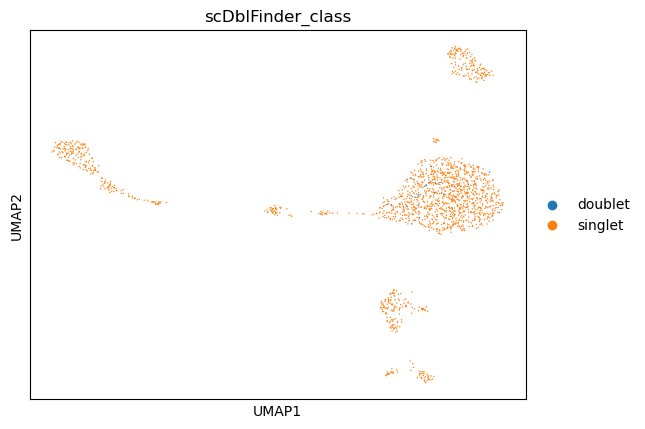

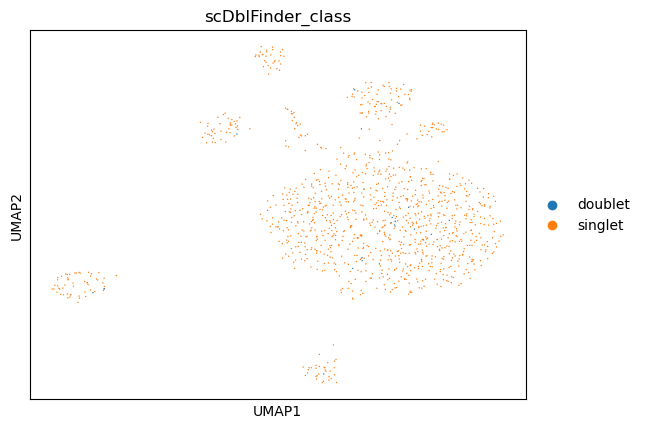

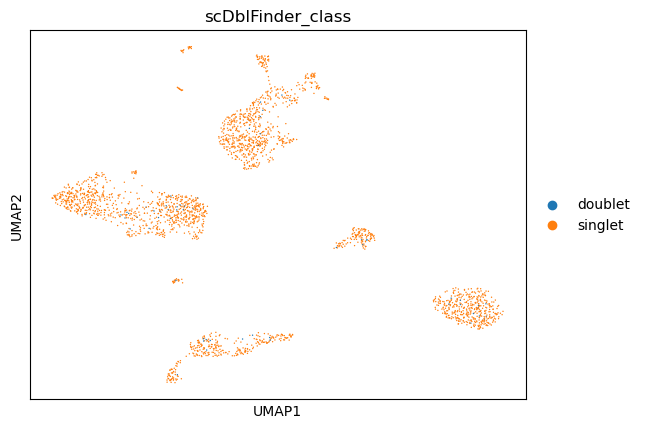

In [2]:
import anndata as ad

processed_list = ['../Output/HF_mes_PVAT_normalized.h5ad', 
                  '../Output/mes2X_PVAT_normalized.h5ad', 
                  '../Output/RP_fat_normalized.h5ad',]

adata_list = []
for p in processed_list:
    adata =ad.read(p)
    sc.pl.umap(adata, color=["scDblFinder_class"],
               size = 4,
               save=str(adata.obs['biosample_id'][0]) + '_doublet_visualization.png')

    adata = adata[adata.obs["scDblFinder_class"] != 'doublet']
    
    adata_list.append(adata)

merged_adata = sc.concat(adata_list, join='outer', index_unique=None, fill_value=0)

# Make observation names unique
merged_adata.obs_names_make_unique()


In [3]:
layer_name = 'soupX_counts'

sc.pp.normalize_total(merged_adata, target_sum=1e4, layers=[layer_name])
sc.pp.log1p(merged_adata, layer=layer_name)

merged_adata_raw = merged_adata.copy()

In [4]:
sc.pp.highly_variable_genes(merged_adata, n_top_genes = 0.25 * len(adata.obs), subset = True, layer = 'soupX_counts',
                            flavor = 'seurat_v3', batch_key = 'biosample_id')

In [5]:
import scvi

scvi.model.SCVI.setup_anndata(
    merged_adata,
    layer="soupX_counts",
    categorical_covariate_keys=["biosample_id", "tissue", "diet"],
    continuous_covariate_keys=["pct_counts_mt", "total_counts"]
)


model = scvi.model.SCVI(merged_adata, n_layers = 3)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
model.train()

#Saving the model
model.save('./models/mes_RP_integration_scvi_2')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████| 400/400 [20:40<00:00,  2.72s/it, loss=62.2, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████| 400/400 [20:40<00:00,  3.10s/it, loss=62.2, v_num=1]


In [7]:
latent = model.get_latent_representation()
latent.shape

merged_adata.obsm["X_scVI"] = latent
merged_adata.layers["scvi_normalized"] = model.get_normalized_expression(library_size=1e4)

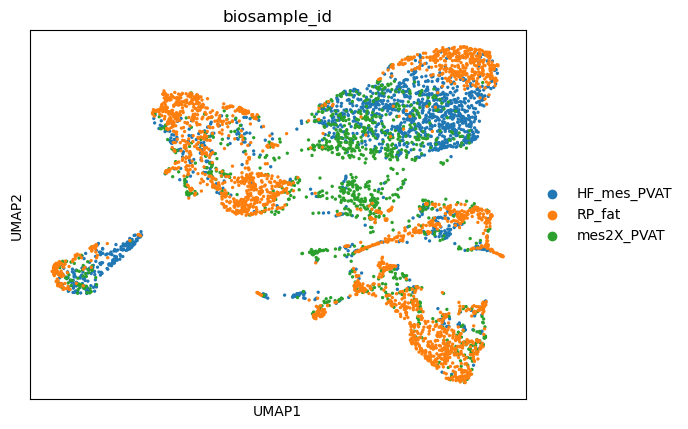

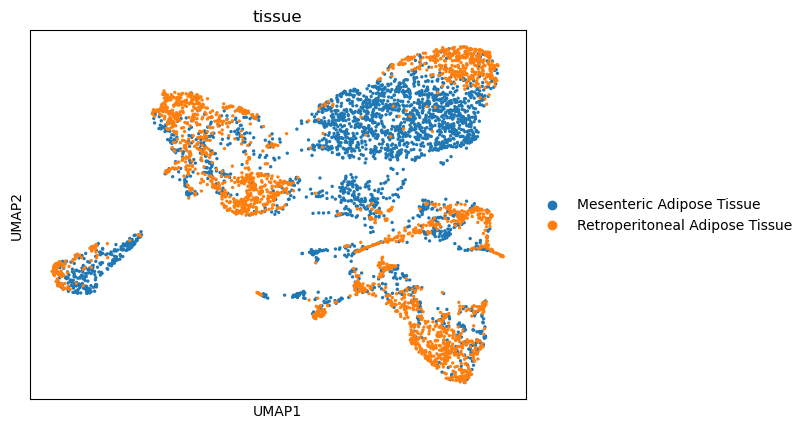

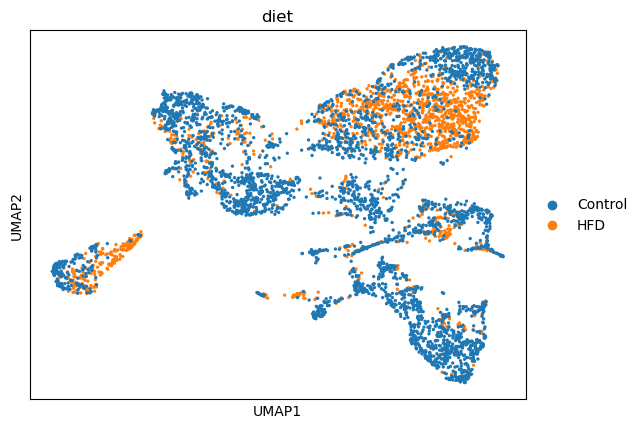

In [8]:
sc.pp.neighbors(merged_adata, use_rep="X_scVI", random_state = 3)
sc.tl.umap(merged_adata, min_dist = 0.2)

sc.pl.umap(merged_adata, color = "biosample_id", save = '_integrated_biosample_id.pdf')
sc.pl.umap(merged_adata, color = "tissue", save = '_integrated_tissue.pdf')
sc.pl.umap(merged_adata, color = "diet", save = '_integrated_diet.pdf')

In [9]:
merged_adata_raw.obsm = merged_adata.obsm.copy()
merged_adata_raw.obsp = merged_adata.obsp.copy()
merged_adata_raw.uns = merged_adata.uns.copy()

<Axes: title={'center': 'leiden1.5'}, xlabel='UMAP1', ylabel='UMAP2'>

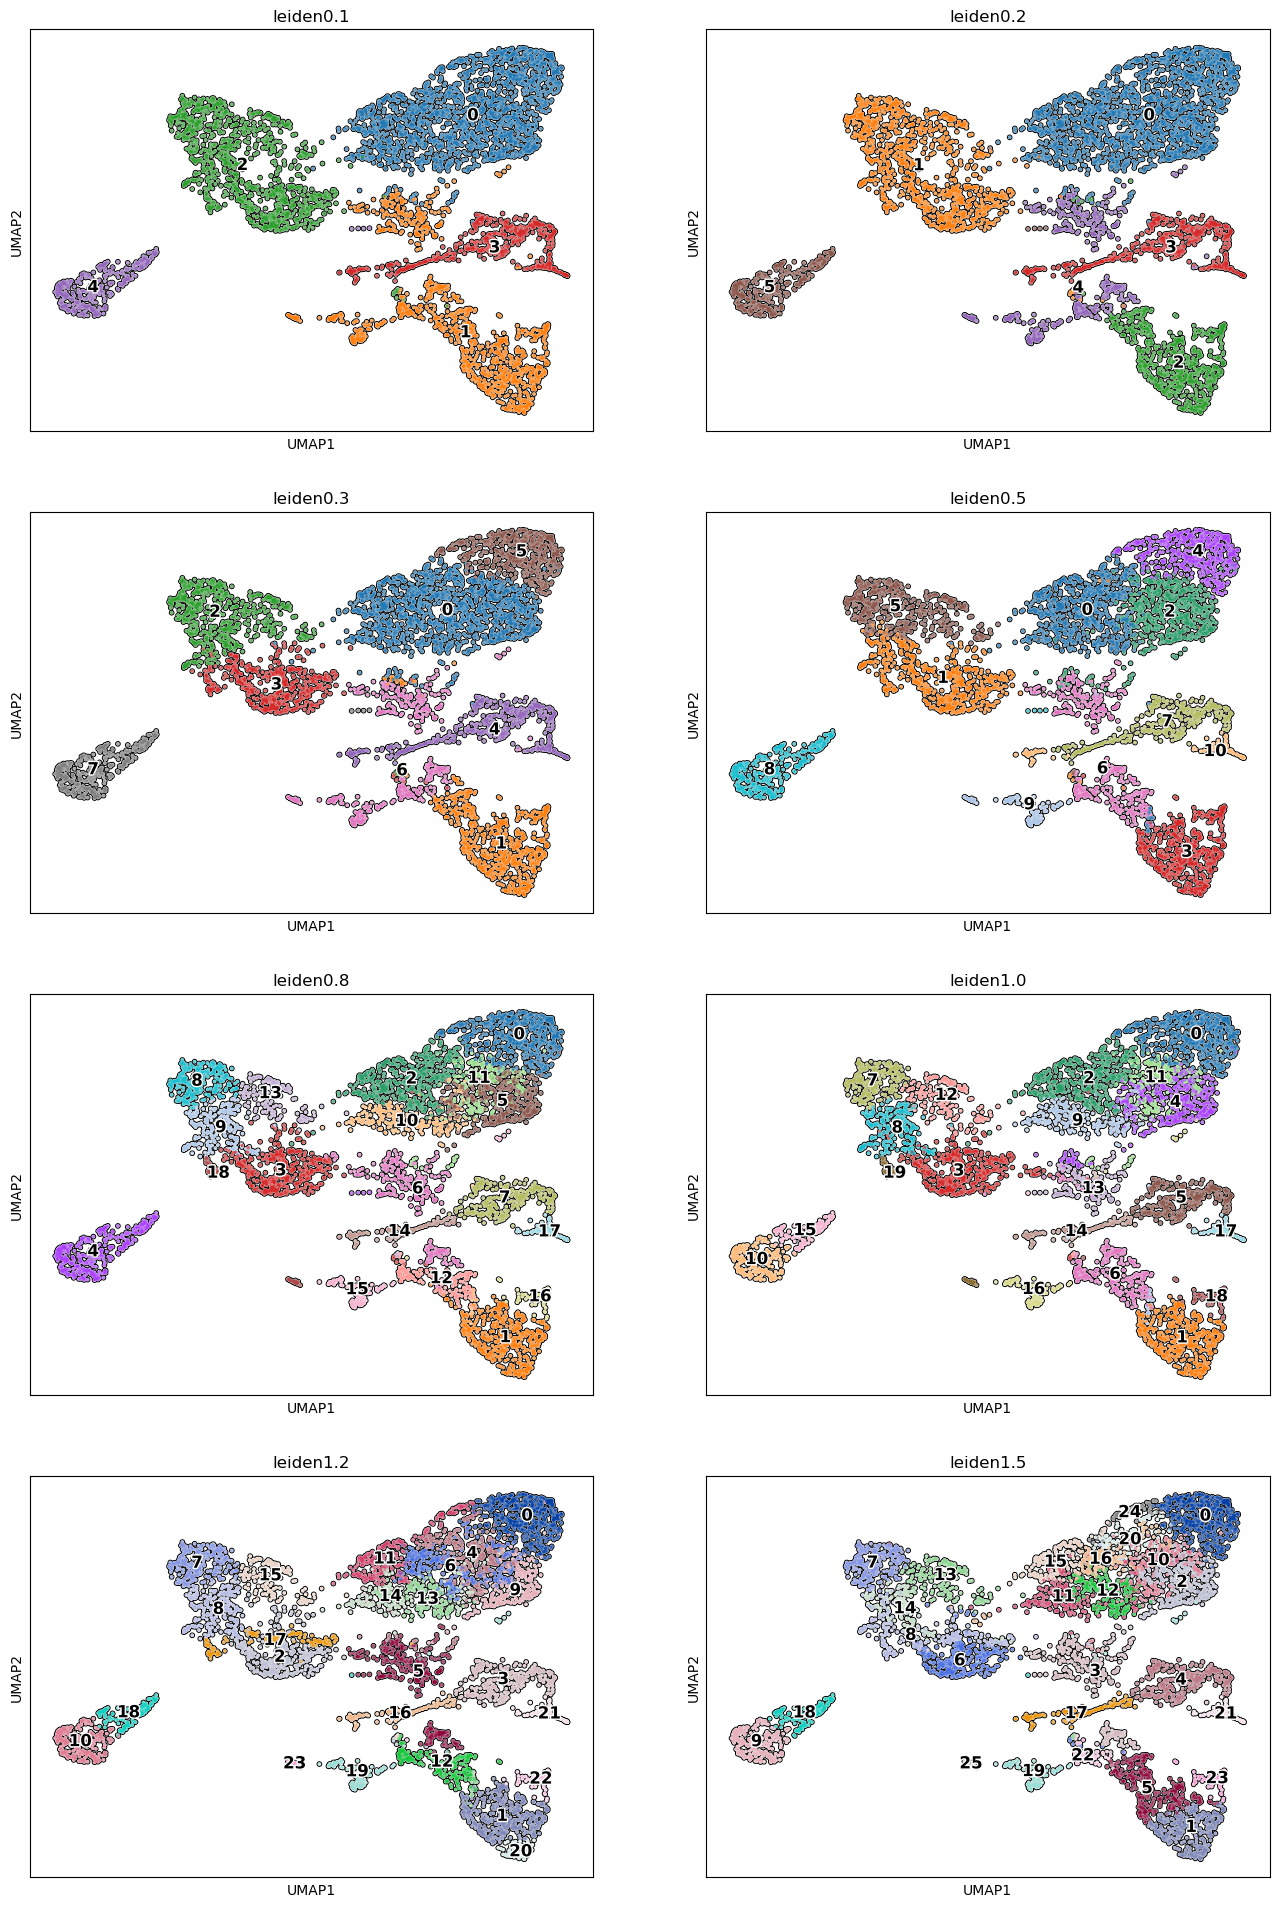

In [10]:
#Plots leiden clusters on the umap using multiple resolutions so the best fit can be picked
def plot_leiden_umap(resolution = 1, row = 0, col = 0):
    sc.tl.leiden(merged_adata_raw, use_weights= True, resolution = resolution, key_added = 'leiden' + str(resolution))
    umap = sc.pl.umap(merged_adata_raw, ax = ax[row,col], color=['leiden' + str(resolution)], add_outline=True, legend_loc='on data',
                   legend_fontsize=12, legend_fontoutline=2,frameon=True, show = False)
    return umap

fig, ax = plt.subplots(nrows = 4, ncols = 2, figsize = (16,24))

plot_leiden_umap(0.1,0,0)
plot_leiden_umap(0.2,0,1)
plot_leiden_umap(0.3,1,0)
plot_leiden_umap(0.5,1,1)
plot_leiden_umap(0.8,2,0)
plot_leiden_umap(1.0,2,1)
plot_leiden_umap(1.2,3,0)
plot_leiden_umap(1.5,3,1)

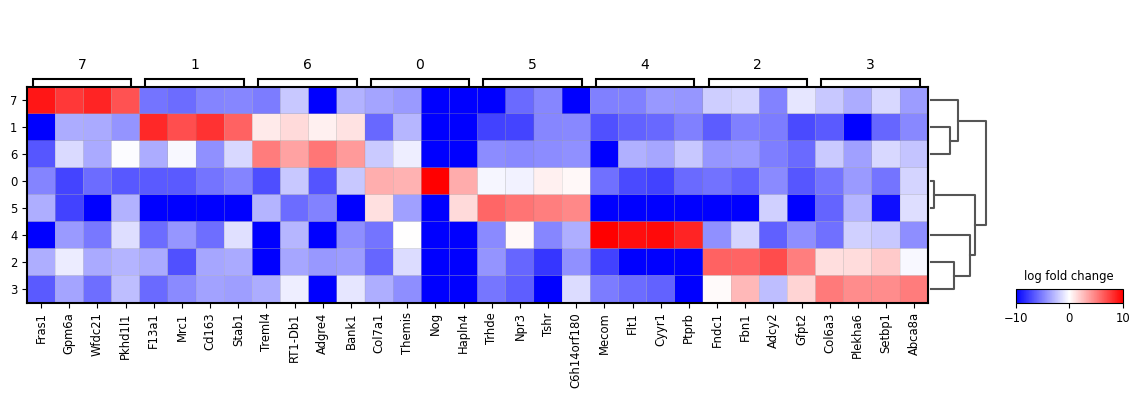

In [11]:
## May need to run this to get rank_genes_groups to work
merged_adata_raw.uns['log1p']["base"] = None

sc.tl.rank_genes_groups(merged_adata_raw, groupby = 'leiden0.3', method='wilcoxon', 
                        use_raw = False, layer='counts', tie_correct = True, pts = True)

sc.tl.dendrogram(merged_adata_raw, groupby = 'leiden')

sc.pl.rank_genes_groups_matrixplot(
    merged_adata_raw,
    n_genes=4,
    values_to_plot="logfoldchanges",
    cmap='bwr',
    vmin=-10,
    vmax=10,
    min_logfoldchange=3,
    colorbar_title='log fold change',
    save = '_integrated_rat_adipose_markers'
)

In [12]:
merged_adata_raw.layers['SoupX_Norm'] = merged_adata_raw.X

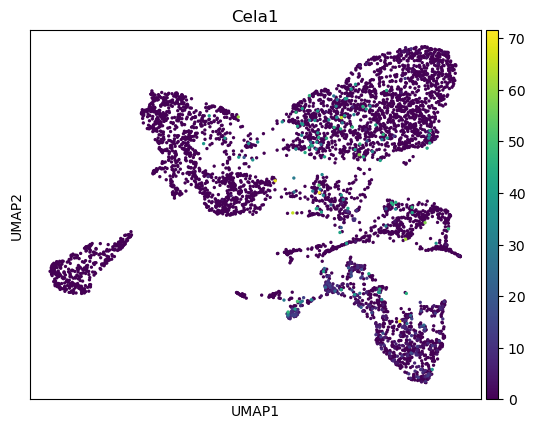

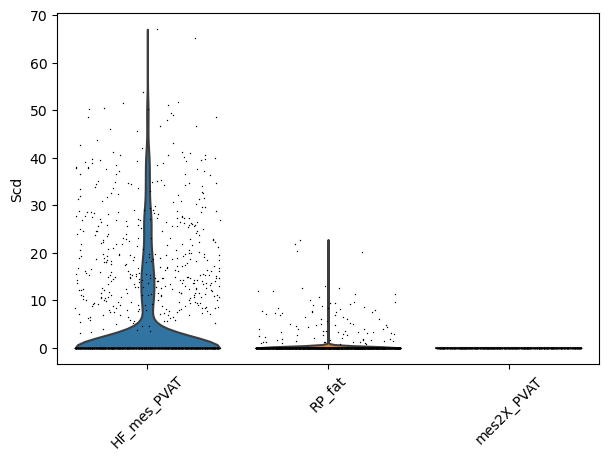

In [18]:
sc.pl.umap(merged_adata_raw, color = ["Cela1"])
sc.pl.violin(merged_adata_raw, keys='Scd', groupby='biosample_id', jitter=0.4, rotation=45)                          

In [74]:
merged_adata.obs

biosample_id donor_id          species  \
AAACCCACATCAGTGT-1  HF_mes_PVAT     D001  NCBITaxon_10116   
AAACGAAAGCATCAGG-1  HF_mes_PVAT     D001  NCBITaxon_10116   
AAACGAACACGGCTAC-1  HF_mes_PVAT     D001  NCBITaxon_10116   
AAACGAAGTCACTGAT-1  HF_mes_PVAT     D001  NCBITaxon_10116   
AAACGAATCCTCTAGC-1  HF_mes_PVAT     D001  NCBITaxon_10116   
...                         ...      ...              ...   
TTTGGTTCAGTCGAGA-1       RP_fat     D003  NCBITaxon_10116   
TTTGTTGCACCCTGAG-1       RP_fat     D003  NCBITaxon_10116   
TTTGTTGGTATAATGG-1       RP_fat     D003  NCBITaxon_10116   
TTTGTTGTCCGAAATC-1       RP_fat     D003  NCBITaxon_10116   
TTTGTTGTCTTGATTC-1       RP_fat     D003  NCBITaxon_10116   

                   species__ontology_label       disease  \
AAACCCACATCAGTGT-1       Rattus norvegicus  PATO_0000461   
AAACGAAAGCATCAGG-1       Rattus norvegicus  PATO_0000461   
AAACGAACACGGCTAC-1       Rattus norvegicus  PATO_0000461   
AAACGAAGTCACTGAT-1       Rattus norvegicus  PATO_0000461   
AAACGAATCCTCTAGC-1       Rattus norvegicus  PATO_0000461   
...                                    ...           ...   
TTTGGTTCAGTCGAGA-1       Rattus norvegicus  PATO_0000461   
TTTGTTGCACCCTGAG-1       Rattus norvegicus  PATO_0000461   
TTTGTTGGTATAATGG-1       Rattus norvegicus  PATO_0000461   
TTTGTTGTCCGAAATC-1       Rattus norvegicus  PATO_0000461   
TTTGTTGTCTTGATTC-1       Rattus norvegicus  PATO_0000461   

                   disease__ontology_label           organ  \
AAACCCACATCAGTGT-1                  Normal  UBERON_0001013   
AAACGAAAGCATCAGG-1                  Normal  UBERON_0001013   
AAACGAACACGGCTAC-1                  Normal  UBERON_0001013   
AAACGAAGTCACTGAT-1                  Normal  UBERON_0001013   
AAACGAATCCTCTAGC-1                  Normal  UBERON_0001013   
...                                    ...             ...   
TTTGGTTCAGTCGAGA-1                  Normal  UBERON_0001013   
TTTGTTGCACCCTGAG-1                  Normal  UBERON_0001013   
TTTGTTGGTATAATGG-1                  Normal  UBERON_0001013   
TTTGTTGTCCGAAATC-1                  Normal  UBERON_0001013   
TTTGTTGTCTTGATTC-1                  Normal  UBERON_0001013   

                   organ__ontology_label library_preparation_protocol  \
AAACCCACATCAGTGT-1        Adipose tissue                  EFO_0009922   
AAACGAAAGCATCAGG-1        Adipose tissue                  EFO_0009922   
AAACGAACACGGCTAC-1        Adipose tissue                  EFO_0009922   
AAACGAAGTCACTGAT-1        Adipose tissue                  EFO_0009922   
AAACGAATCCTCTAGC-1        Adipose tissue                  EFO_0009922   
...                                  ...                          ...   
TTTGGTTCAGTCGAGA-1        Adipose tissue                  EFO_0009922   
TTTGTTGCACCCTGAG-1        Adipose tissue                  EFO_0009922   
TTTGTTGGTATAATGG-1        Adipose tissue                  EFO_0009922   
TTTGTTGTCCGAAATC-1        Adipose tissue                  EFO_0009922   
TTTGTTGTCTTGATTC-1        Adipose tissue                  EFO_0009922   

                   library_preparation_protocol__ontology_label  ...  \
AAACCCACATCAGTGT-1                                    10x 3' v3  ...   
AAACGAAAGCATCAGG-1                                    10x 3' v3  ...   
AAACGAACACGGCTAC-1                                    10x 3' v3  ...   
AAACGAAGTCACTGAT-1                                    10x 3' v3  ...   
AAACGAATCCTCTAGC-1                                    10x 3' v3  ...   
...                                                         ...  ...   
TTTGGTTCAGTCGAGA-1                                    10x 3' v3  ...   
TTTGTTGCACCCTGAG-1                                    10x 3' v3  ...   
TTTGTTGGTATAATGG-1                                    10x 3' v3  ...   
TTTGTTGTCCGAAATC-1                                    10x 3' v3  ...   
TTTGTTGTCTTGATTC-1                                    10x 3' v3  ...   

                   total_counts_ribo log1p_total_counts_ribo pct_counts_ribo  

### Data repositories and sources

In [ ]:
!ls

### Setting up python analysis environment